## Load Datasets

In [17]:

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_boston
from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from google.cloud import bigquery

import tensorflow as tf
import keras
from keras import models, layers
import matplotlib.pyplot as plt
keras.__version__

Using TensorFlow backend.


KeyboardInterrupt: 

In [ ]:
housing = fetch_california_housing(as_frame=True)
housing = pd.DataFrame(data= np.c_[housing['data'], housing['target']],
                     columns= housing['feature_names'] + ['target'])
housing.head()

In [3]:
gamesDF = pd.read_csv("https://github.com/bgweber/Twitch/raw/master/Recommendations/games-expand.csv")
gamesDF.head()

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,label
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,1,0,0,1,1
4,0,0,1,0,1,1,0,1,1,0,1


### BigQuery to Pandas

In [4]:
client = bigquery.Client()
sql = """
SELECT * 
FROM `bigquery-public-data.samples.natality`
limit 10
"""

In [5]:
natalityDF = client.query(sql).to_dataframe()
natalityDF.head()

,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,...,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
0,1970,1970,9,4,<NA>,HI,True,7,7.625790,<NA>,...,<NA>,<NA>,<NA>,7,0,0,8,7,46,2
1,1971,1971,6,2,<NA>,HI,False,6,7.438397,1,...,<NA>,<NA>,<NA>,11,0,0,12,6,47,2
2,1972,1972,11,27,<NA>,HI,False,7,8.437091,1,...,<NA>,<NA>,<NA>,12,0,0,13,7,48,2
3,1972,1972,11,10,<NA>,HI,True,7,7.374463,1,...,<NA>,<NA>,<NA>,6,0,3,10,7,34,2
4,1973,1973,12,26,<NA>,HI,False,7,5.813590,1,...,<NA>,<NA>,<NA>,8,0,1,10,7,49,2


### Kaggle to Pandas

In [6]:
nhlDF = pd.read_csv('../data/game.csv')
nhlDF.head()

,game_id,season,type,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2016020045,20162017,R,2016-10-19T00:30:00Z,4,16,4,7,home win REG,right,United Center,/api/v1/venues/null,America/Chicago,-5,CDT
1,2017020812,20172018,R,2018-02-07T00:00:00Z,24,7,4,3,away win OT,left,KeyBank Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2015020314,20152016,R,2015-11-24T01:00:00Z,21,52,4,1,away win REG,right,MTS Centre,/api/v1/venues/null,America/Winnipeg,-5,CDT
3,2015020849,20152016,R,2016-02-17T00:00:00Z,52,12,1,2,home win REG,right,PNC Arena,/api/v1/venues/null,America/New_York,-4,EDT
4,2017020586,20172018,R,2017-12-30T03:00:00Z,20,24,1,2,home win REG,left,Honda Center,/api/v1/venues/null,America/Los_Angeles,-7,PDT


## Prototype models

### Linear regression

In [7]:
# See Section 1.4 (Boston Hosing data set)
x_train, x_test, y_train, y_test = train_test_split(
  housing.drop(['target'],axis=1),housing['target'],test_size=0.3)
model = LinearRegression()
model.fit(x_train, y_train)
print("R^2: " + str(model.score(x_test, y_test)))
print("Mean Error: " + str(sum(
      abs(y_test - model.predict(x_test) ))/y_test.count()))

R^2: 0.5970364297906141
Mean Error: 0.5380748728712478


### Logistic regression

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    gamesDF.drop(['label'],axis=1),gamesDF['label'],test_size=0.3)
model = LogisticRegression()
model.fit(x_train, y_train)
print("Accuracy: " + str(model.score(x_test, y_test)))
print("ROC: " + str(roc_auc_score(y_test,
                    model.predict_proba(x_test)[:, 1] )))

Accuracy: 0.875
ROC: 0.7709134146707262


### Simple neural network

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
  gamesDF.drop(['label'], axis=1),gamesDF['label'],test_size=0.3)
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10,)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# define ROC AUC as a metric
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    keras.backend.get_session().run(
                  tf.local_variables_initializer())
    return auc

# compile and fit the model
model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy', metrics=[auc])
history = model.fit(x_train, y_train, epochs=100, batch_size=100,
                 validation_split = .2, verbose=0)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2022-06-12 12:56:59.102934: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-12 12:56:59.138541: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400015000 Hz
2022-06-12 12:56:59.138808: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3e55790 executing computations on platform Host. Devices:
2022-06-12 12:56:59.138832: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-06-12 12:56:59.243462: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

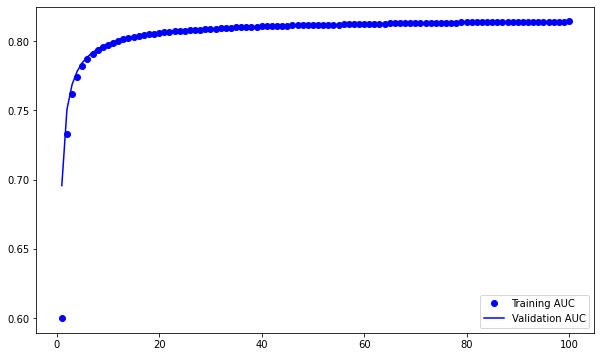

In [10]:
loss = history.history['auc']
val_loss = history.history['val_auc']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label='Training AUC')
plt.plot(epochs, val_loss, 'b', label='Validation AUC')
plt.legend()
plt.show()

In [11]:
results = model.evaluate(x_test, y_test, verbose=0)
print("ROC: " + str(results[1]))

ROC: 0.8141191361669334


# Automate Feature Engineering using FeatureTools

In [1]:
import pandas as pd
import numpy as np
game_df = pd.read_csv('../data/game.csv')
plays_df = pd.read_csv('../data/game_plays.csv')


In [2]:
#preprocess games df
game_df = game_df.drop_duplicates(subset=['game_id'])
game_df=game_df.fillna(0)

In [3]:
# preprocess plays dataframe
plays_df=plays_df.fillna(0)
plays_df = plays_df.drop(['secondaryType', 'periodType', 'dateTime'], axis=1).fillna(0)

# play_id is not unique, so create a new index column
plays_df['play_id2'] = range(1, len(plays_df) + 1)

# truncating data frame bc running on memory issues on t3.medium instance
plays_df = plays_df.iloc[:3000000]

# change order to push index to the front
cols = list(plays_df.columns)
cols = cols[-1:] + cols[:-1]
plays_df = plays_df[cols]

# remove unique descriptions using count limit
plays_df.loc[plays_df.groupby('description').description.transform('count').lt(50000), 'description'] = np.nan 

In [4]:
plays_df.head()

,play_id2,play_id,game_id,team_id_for,team_id_against,event,x,y,period,periodTime,periodTimeRemaining,goals_away,goals_home,description,st_x,st_y
0,1,2016020045_1,2016020045,0.0,0.0,Game Scheduled,0.0,0.0,1,0,1200.0,0,0,NaN,0.0,0.0
1,2,2016020045_2,2016020045,0.0,0.0,Period Ready,0.0,0.0,1,0,1200.0,0,0,NaN,0.0,0.0
2,3,2016020045_3,2016020045,0.0,0.0,Period Start,0.0,0.0,1,0,1200.0,0,0,NaN,0.0,0.0
3,4,2016020045_4,2016020045,16.0,4.0,Faceoff,0.0,0.0,1,0,1200.0,0,0,NaN,0.0,0.0
4,5,2016020045_5,2016020045,16.0,4.0,Shot,-71.0,9.0,1,54,1146.0,0,0,NaN,71.0,-9.0


In [5]:
game_df.head()

,game_id,season,type,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2016020045,20162017,R,2016-10-19T00:30:00Z,4,16,4,7,home win REG,right,United Center,/api/v1/venues/null,America/Chicago,-5,CDT
1,2017020812,20172018,R,2018-02-07T00:00:00Z,24,7,4,3,away win OT,left,KeyBank Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2015020314,20152016,R,2015-11-24T01:00:00Z,21,52,4,1,away win REG,right,MTS Centre,/api/v1/venues/null,America/Winnipeg,-5,CDT
3,2015020849,20152016,R,2016-02-17T00:00:00Z,52,12,1,2,home win REG,right,PNC Arena,/api/v1/venues/null,America/New_York,-4,EDT
4,2017020586,20172018,R,2017-12-30T03:00:00Z,20,24,1,2,home win REG,left,Honda Center,/api/v1/venues/null,America/Los_Angeles,-7,PDT



plays_df.ww.set_types(logical_types={
    'play_id': Categorical,
    'game_id': Categorical,
    'team_id_for': Categorical, 
    'team_id_against': Categorical, 
    'event': Categorical, 
    'x': Integer,
    'y':Integer, 
    'period':Categorical, 
    'periodTime':Categorical, 
    'periodTimeRemaining':Double, 
    'goals_away':Integer,
    'goals_home':Integer, 
    'description':Categorical, 
    'st_x':Integer, 
    'st_y':Integer, 
    'play_id2':Categorical
})


In [8]:
# one hot encode plays dataframe
import featuretools as ft
import woodwork as ww
from woodwork.logical_types import Categorical

# newest version of featuretools uses woodwork for typing
#initialize woodwork dataframe
plays_df.ww.init(name="plays", index='play_id2')

#initialize entity set
es = ft.EntitySet(id="plays")

es = es.add_dataframe(dataframe_name="plays",
                      dataframe=plays_df,
                      )

# get one-hot encoding for plays features
plays_feature_matrix, plays_feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="plays",
                                      max_depth=1)

plays_encoded, plays_defs = ft.encode_features(plays_feature_matrix, plays_feature_defs)
plays_encoded.reset_index(inplace=True)

# convert trues and falses to 0s and 1s
plays_encoded=plays_encoded*1
# delete the feature matrices to save memory
del plays_feature_matrix
del plays_feature_defs
del plays_df
plays_encoded.head()

/home/ec2-user/.local/lib/python3.7/site-packages/woodwork/__init__.py:23: FutureWarning: Woodwork may not support Python 3.7 in next non-bugfix release.
  "Woodwork may not support Python 3.7 in next non-bugfix release.", FutureWarning
/home/ec2-user/.local/lib/python3.7/site-packages/featuretools/__init__.py:67: FutureWarning: Featuretools may not support Python 3.7 in next non-bugfix release.
  FutureWarning,


,play_id2,game_id,team_id_for,team_id_against,x,y,period,periodTime,periodTimeRemaining,goals_away,...,event = Missed Shot,event = Giveaway,event = Takeaway,event = Penalty,event = Goal,event is unknown,description = Goalie Stopped,description = Icing,description = Offside,description is unknown
0,1,2016020045,0.0,0.0,0.0,0.0,1,0,1200.0,0,...,0,0,0,0,0,1,0,0,0,1
1,2,2016020045,0.0,0.0,0.0,0.0,1,0,1200.0,0,...,0,0,0,0,0,1,0,0,0,1
2,3,2016020045,0.0,0.0,0.0,0.0,1,0,1200.0,0,...,0,0,0,0,0,1,0,0,0,1
3,4,2016020045,16.0,4.0,0.0,0.0,1,0,1200.0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,2016020045,16.0,4.0,-71.0,9.0,1,54,1146.0,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
plays_encoded.columns

Index(['play_id2', 'game_id', 'team_id_for', 'team_id_against', 'x', 'y',
       'period', 'periodTime', 'periodTimeRemaining', 'goals_away',
       'goals_home', 'st_x', 'st_y', 'event = Faceoff', 'event = Shot',
       'event = Stoppage', 'event = Hit', 'event = Blocked Shot',
       'event = Missed Shot', 'event = Giveaway', 'event = Takeaway',
       'event = Penalty', 'event = Goal', 'event is unknown',
       'description = Goalie Stopped', 'description = Icing',
       'description = Offside', 'description is unknown'],
      dtype='object')

In [10]:
# create a duplicate index column so that the dfs does not throw an error for a child relationship
plays_encoded['play_id3'] = plays_encoded['play_id2']

In [11]:
plays_encoded = plays_encoded.drop(labels=['team_id_for', 'team_id_against', 'x', 'y',
       'period', 'periodTime', 'periodTimeRemaining', 'goals_away',
       'goals_home', 'st_x', 'st_y'],axis=1)

In [12]:
plays_encoded.shape

(3000000, 18)

In [32]:
games_encoded = game_df

In [13]:
plays_encoded.ww.init(name="plays_encoded", index='play_id2')
games_encoded.ww.init(name="games_encoded", index='game_id')

In [14]:
# combine games encoded and plays encoded in a parent child relationship
# run dfs to get various aggregations
# create dataframes and relationship columns
dataframes = {
   "plays_encoded" : (plays_encoded, "play_id2"),
   "games_encoded" : (games_encoded, "game_id")
}

#(parent_dataframe, parent_column, child_dataframe, child_column)
relationships = [("games_encoded", "game_id", "plays_encoded", "play_id3")]

# create feature matrix of all combos
feature_matrix, features_defs = ft.dfs(
                                       dataframes=dataframes,
                                       relationships=relationships,
                                       target_dataframe_name="games_encoded",
                                       max_depth=2
                                        )
feature_matrix

/home/ec2-user/.local/lib/python3.7/site-packages/featuretools/entityset/entityset.py:749: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  + ", ".join(extra_params)
/home/ec2-user/.local/lib/python3.7/site-packages/pandas/core/frame.py:4486: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)


,season,type,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,...,SUM(plays_encoded.event = Penalty),SUM(plays_encoded.event = Shot),SUM(plays_encoded.event = Stoppage),SUM(plays_encoded.event = Takeaway),SUM(plays_encoded.event is unknown),SUM(plays_encoded.game_id),DAY(date_time_GMT),MONTH(date_time_GMT),WEEKDAY(date_time_GMT),YEAR(date_time_GMT)
game_id,,,,,,,,,,,,,,,,,,,,,
2016020045,20162017,R,4,16,4,7,home win REG,right,United Center,/api/v1/venues/null,...,0.0,0.0,0.0,0.0,0.0,0.0,19,10,2,2016
2017020812,20172018,R,24,7,4,3,away win OT,left,KeyBank Center,/api/v1/venues/null,...,0.0,0.0,0.0,0.0,0.0,0.0,7,2,2,2018
2015020314,20152016,R,21,52,4,1,away win REG,right,MTS Centre,/api/v1/venues/null,...,0.0,0.0,0.0,0.0,0.0,0.0,24,11,1,2015
2015020849,20152016,R,52,12,1,2,home win REG,right,PNC Arena,/api/v1/venues/null,...,0.0,0.0,0.0,0.0,0.0,0.0,17,2,2,2016
2017020586,20172018,R,20,24,1,2,home win REG,left,Honda Center,/api/v1/venues/null,...,0.0,0.0,0.0,0.0,0.0,0.0,30,12,5,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018030413,20182019,P,6,19,7,2,away win REG,left,Enterprise Center,/api/v1/venues/5076,...,0.0,0.0,0.0,0.0,0.0,0.0,2,6,6,2019
2018030414,20182019,P,6,19,2,4,home win REG,left,Enterprise Center,/api/v1/venues/5076,...,0.0,0.0,0.0,0.0,0.0,0.0,4,6,1,2019
2018030415,20182019,P,19,6,2,1,away win REG,left,TD Garden,/api/v1/venues/5085,...,0.0,0.0,0.0,0.0,0.0,0.0,7,6,4,2019


In [15]:
feature_matrix.describe()

,season,away_team_id,home_team_id,away_goals,home_goals,venue_time_zone_offset,COUNT(plays_encoded),MAX(plays_encoded.description = Goalie Stopped),MAX(plays_encoded.description = Icing),MAX(plays_encoded.description = Offside),...,SUM(plays_encoded.event = Giveaway),SUM(plays_encoded.event = Goal),SUM(plays_encoded.event = Hit),SUM(plays_encoded.event = Missed Shot),SUM(plays_encoded.event = Penalty),SUM(plays_encoded.event = Shot),SUM(plays_encoded.event = Stoppage),SUM(plays_encoded.event = Takeaway),SUM(plays_encoded.event is unknown),SUM(plays_encoded.game_id)
count,2.373500e+04,23735.000000,23735.000000,23735.000000,23735.000000,23735.000000,23735.0,0.0,0.0,0.0,...,23735.0,23735.0,23735.0,23735.0,23735.0,23735.0,23735.0,23735.0,23735.0,23735.0
mean,2.010108e+07,16.633031,16.635812,2.667032,2.941268,-4.986897,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,5.804577e+04,10.782856,10.797031,1.611264,1.681846,1.186262,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,2.000200e+07,1.000000,1.000000,0.000000,0.000000,-8.000000,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.005201e+07,8.000000,8.000000,1.000000,2.000000,-6.000000,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2.010201e+07,16.000000,16.000000,3.000000,3.000000,-5.000000,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,2.015202e+07,24.000000,24.000000,4.000000,4.000000,-4.000000,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.019202e+07,90.000000,90.000000,11.000000,12.000000,-4.000000,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
list(feature_matrix.columns)

['season',
 'type',
 'away_team_id',
 'home_team_id',
 'away_goals',
 'home_goals',
 'outcome',
 'home_rink_side_start',
 'venue',
 'venue_link',
 'venue_time_zone_id',
 'venue_time_zone_offset',
 'venue_time_zone_tz',
 'COUNT(plays_encoded)',
 'MAX(plays_encoded.description = Goalie Stopped)',
 'MAX(plays_encoded.description = Icing)',
 'MAX(plays_encoded.description = Offside)',
 'MAX(plays_encoded.description is unknown)',
 'MAX(plays_encoded.event = Blocked Shot)',
 'MAX(plays_encoded.event = Faceoff)',
 'MAX(plays_encoded.event = Giveaway)',
 'MAX(plays_encoded.event = Goal)',
 'MAX(plays_encoded.event = Hit)',
 'MAX(plays_encoded.event = Missed Shot)',
 'MAX(plays_encoded.event = Penalty)',
 'MAX(plays_encoded.event = Shot)',
 'MAX(plays_encoded.event = Stoppage)',
 'MAX(plays_encoded.event = Takeaway)',
 'MAX(plays_encoded.event is unknown)',
 'MAX(plays_encoded.game_id)',
 'MEAN(plays_encoded.description = Goalie Stopped)',
 'MEAN(plays_encoded.description = Icing)',
 'MEAN(pla

In [17]:
game_df['type'].value_counts()

R    22806
P      924
A        5
Name: type, dtype: int64

In [18]:
feature_matrix = feature_matrix.drop(labels=['season',
 'type',
 'away_team_id',
 'home_team_id',
 'away_goals',
 'home_goals',
 'outcome',
 'home_rink_side_start',
 'venue',
 'venue_link',
 'venue_time_zone_id',
 'venue_time_zone_offset',
 'venue_time_zone_tz'],axis=1)

In [19]:
feature_matrix.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
feature_matrix = pd.merge(feature_matrix, game_df[['game_id', 'type', 'venue_time_zone_offset']], how='left', on='game_id')

In [20]:
feature_matrix.shape

(23735, 104)

In [21]:
feature_matrix = feature_matrix.drop(labels=['game_id'], axis=1)
feature_matrix = feature_matrix.reset_index()

In [22]:
type(feature_matrix)

pandas.core.frame.DataFrame

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
# create inputs for sklearn
y = feature_matrix['type']
X = feature_matrix.drop(labels=['type'], axis=1)

y = pd.Categorical(y)
for col in X:
    X[col] = pd.Categorical(X[col])

# train a classifier
lr = LogisticRegression()
model = lr.fit(X,y)

print("Accuracy: ", str(model.score(X,y)))
print("ROC " + str(roc_auc_score(y,model.predict_proba(X),multi_class='ovr')))

/home/ec2-user/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/ec2-user/.local/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


Accuracy:  0.9602275121129135
ROC 0.9358017854785222


/home/ec2-user/.local/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


In [23]:
X.shape

(23735, 199)

In [24]:
y.shape

(23735,)

In [25]:
len(y)

23735